# Toxic Comments Challenge

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD

/home/aaron/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aaron/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aaron/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aaron/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

### Load Data 

In [2]:
train_df = pd.read_csv("./train.csv").fillna("blank")
train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Clean the data 

In [3]:
#CLEANING HERE
train_df['comment_text'] = train_df['comment_text'].str.replace('\n', ' ')
train_df['comment_text'] = train_df['comment_text'].str.lower()
train_df['comment_text'] = train_df['comment_text'].str.replace(r'[\W]', ' ')
train_df['comment_text'] = train_df['comment_text'].str.strip()

In [4]:
train_samples = train_df["comment_text"].values
train_labels = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.backend.tensorflow_backend import set_session

config = ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True  # to log device placement (on which device the operation ran)
session = InteractiveSession(config=config)
tf.keras.backend.set_session(session)

Using TensorFlow backend.


### Tokenise and and pad words 

In [6]:
x_train, x_test, y_train, y_test = train_test_split(train_samples, train_labels, test_size=0.2)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

BATCH_SIZE = 512
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# second, prepare text samples and their labels
print('Processing text dataset')

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(list(x_train))
sequences = tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

data_train, val_test, data_label, val_label = train_test_split(data, y_train, test_size=0.2)

Processing text dataset
Found 163402 unique tokens.


### Build the model 

In [7]:
tokens_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64', name="SentencesInput")
embedded_sequences = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM)(tokens_input)
x = Conv1D(512, 6, activation='relu')(embedded_sequences)
x = Dropout(0.5)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(256, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 2, activation='relu')(x)
x = Dropout(0.2)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
final = Dense(6, activation='sigmoid')(x)

model = Model(inputs=[tokens_input], outputs=[final])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SentencesInput (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 95, 512)           307712    
_________________________________________________________________
dropout (Dropout)            (None, 95, 512)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 512)           0         
_______________________

### Training the model 

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(data_train, data_label, epochs=5, batch_size=512, validation_data=(val_test, val_label), verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 11s 107us/sample - loss: 0.1171 - acc: 0.9649 - val_loss: 0.1168 - val_acc: 0.9771
Epoch 2/5
102124/102124 [==============================] - 9s 85us/sample - loss: 0.0538 - acc: 0.9809 - val_loss: 0.0863 - val_acc: 0.9808
Epoch 3/5
102124/102124 [==============================] - 9s 86us/sample - loss: 0.0480 - acc: 0.9824 - val_loss: 0.0733 - val_acc: 0.9808
Epoch 4/5
102124/102124 [==============================] - 9s 90us/sample - loss: 0.0438 - acc: 0.9834 - val_loss: 0.0787 - val_acc: 0.9787
Epoch 5/5
102124/102124 [==============================] - 9s 89us/sample - loss: 0.0398 - acc: 0.9846 - val_loss: 0.0678 - val_acc: 0.9793


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


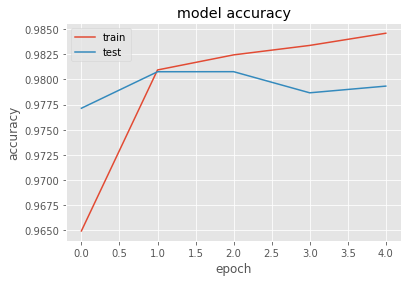

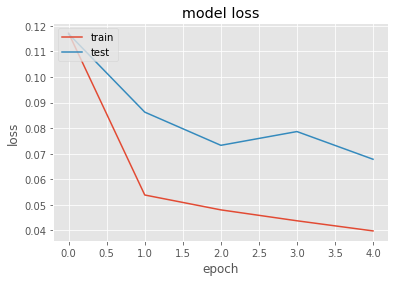

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation 

#### Preprocess test data 

In [10]:
tokenizer.fit_on_texts(list(x_test))
sequences = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_test = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

data_test

Found 186525 unique tokens.


array([[  96,   12,  668, ...,    0,    0,    0],
       [1013, 3907,   44, ...,    0,    0,    0],
       [  13,   25,   26, ...,    0,    0,    0],
       ...,
       [   4,    1, 3209, ..., 1163, 1433, 5067],
       [3349,  106,  252, ...,    0,    0,    0],
       [ 102,   71,    3, ...,    0,    0,    0]], dtype=int32)

In [12]:
# predict crisp classes for test set
yhat = model.predict(data_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [16]:
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

print(multilabel_confusion_matrix(y_test, preds_labels))

#print(average_precision_score(y_test, preds_labels))
#print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(y_test, preds_labels))

[[[25471  3360]
  [ 2537   547]]

 [[31573     0]
  [  342     0]]

 [[28676  1548]
  [ 1560   131]]

 [[31811     0]
  [  104     0]]

 [[29685   621]
  [ 1541    68]]

 [[31618     0]
  [  297     0]]]
ROC AUC Score: 0.5090707077874929
